In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Data/bbca_data_5y.csv')

In [3]:
data['date_str'] = pd.to_datetime(data['date_str'])

In [4]:
# rename columns
data = data.rename(columns={'date_str': 'date'})

In [5]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
0,5633.568658,5660.523532,5615.598742,5651.538574,58420500,0.0,0.0,2019-10-31
1,5660.522959,5682.985352,5638.060566,5682.985352,42080500,0.0,0.0,2019-11-01
2,5705.447725,5732.402596,5624.583111,5638.060547,43794500,0.0,0.0,2019-11-04
3,5705.447660,5714.432617,5633.568005,5714.432617,66161500,0.0,0.0,2019-11-05
4,5732.401911,5732.401911,5656.029785,5656.029785,63393000,0.0,0.0,2019-11-06


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Open          1213 non-null   float64       
 1   High          1213 non-null   float64       
 2   Low           1213 non-null   float64       
 3   Close         1213 non-null   float64       
 4   Volume        1213 non-null   int64         
 5   Dividends     1213 non-null   float64       
 6   Stock Splits  1213 non-null   float64       
 7   date          1213 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 75.9 KB


In [7]:
data.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
date            0
dtype: int64

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [9]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [10]:
# preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

data_scaled

array([[0.23553495, 0.19229606, 0.24972815, 0.23840609, 0.0772317 ],
       [0.23944758, 0.19572598, 0.25299451, 0.24292621, 0.05563028],
       [0.24596877, 0.20327201, 0.25103464, 0.23646878, 0.05789618],
       ...,
       [0.94556572, 0.94273744, 0.96000994, 0.93531759, 0.06567692],
       [0.9092762 , 0.91601491, 0.9272908 , 0.91375679, 0.15134759],
       [0.9165341 , 0.92746742, 0.92365534, 0.89938292, 0.12896526]])

In [11]:
# sequence generator 60 days
sequence_length = 60
x = []
y = []

for i in range(sequence_length, len(data_scaled)):
    x.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i,3])

x, y = np.array(x), np.array(y)

In [12]:
print(x.shape, y.shape)

(1153, 60, 5) (1153,)


In [52]:
# train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [53]:
# LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
# train model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
29/29 [==============================] - 7s 71ms/step - loss: 0.0388 - val_loss: 0.0056
Epoch 2/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0070 - val_loss: 0.0024
Epoch 3/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 5/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 6/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 8/10
29/29 [==============================] - 1s 40ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 10/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0036 - val_loss: 0.0013


In [55]:
# prediction
predicted_prices =  model.predict(x_test)
predicted_prices = scaler.inverse_transform(np.hstack([np.zeros((predicted_prices.shape[0], data.shape[1]-1)), predicted_prices]))


8/8 [==============================] - 1s 15ms/step


In [61]:
real_prices = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1,1)]))

In [62]:
real_prices

array([[4.01095868e+03, 4.40121868e+03, 3.89829088e+03, 3.99293091e+03,
        4.29173028e+08],
       [4.01095868e+03, 4.40121868e+03, 3.89829088e+03, 3.99293091e+03,
        3.16182734e+08],
       [4.01095868e+03, 4.40121868e+03, 3.89829088e+03, 3.99293091e+03,
        5.20471563e+08],
       ...,
       [4.01095868e+03, 4.40121868e+03, 3.89829088e+03, 3.99293091e+03,
        4.93773597e+07],
       [4.01095868e+03, 4.40121868e+03, 3.89829088e+03, 3.99293091e+03,
        7.50995176e+08],
       [4.01095868e+03, 4.40121868e+03, 3.89829088e+03, 3.99293091e+03,
        4.88739091e+08]])

In [63]:
!pip install plotly

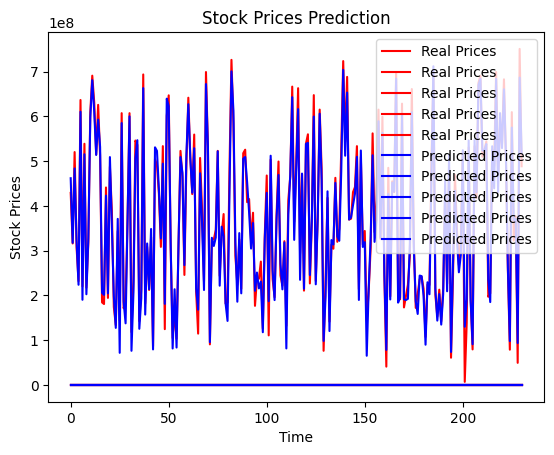

In [64]:
# conpare real and predicted prices
import matplotlib.pyplot as plt

plt.plot(real_prices, color='red', label='Real Prices')
plt.plot(predicted_prices, color='blue', label='Predicted Prices')
plt.title('Stock Prices Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

In [65]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
rmse

12428086.212210793

In [66]:
# count accuracy
accuracy = 1 - rmse / np.mean(real_prices)
accuracy

0.8315961475755802